In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import textwrap

from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity, cosine_distances
from sklearn.neighbors import NearestNeighbors

In [6]:
def file_read_authors():
    df = pd.read_json('./Dataset/goodreads_book_authors.json', lines=True)
    df.rename(columns={'average_rating': 'author_avg_rating', 'author_id': 'authors', 'text_reviews_count': 'aut_txt_rev_count','name': 'author_name', 'ratings_count': 'author_ratings_count'}, inplace=True)
    return df


def file_read(genre):
    df = pd.read_json('./Dataset/goodreads_books_'+ genre +'.json', lines=True)
    df.drop(columns=['isbn', 'series', 'kindle_asin', 'popular_shelves','similar_books','asin', 'is_ebook', 'edition_information', 'publication_year', 'url', 'image_url', 'format', 'link', 'publisher', 'publication_day', 'isbn13', 'publication_month', 'work_id'], inplace=True)
    return df

def fix_author(df):
    '''Extracts the author id from the disctionary of authors'''
    for index in df.index:
        if len(df['authors'][index]) >=1:
            author_id = df['authors'][index][0]['author_id']
            df['authors'][index] = int(author_id)


def add_author_name(df, aut):
    '''adds author's name to df'''
    foo = df.merge(aut[['author_name','authors']], on = 'authors', how = 'left')
    return foo

In [7]:
# init authors df
df_authors = file_read_authors()

# init individual genre dfs and add another column with genre:
df_children = file_read('children')
df_children['genre'] = 'children'

df_comics = file_read('comics_graphic')
df_comics['genre'] = 'comics'

df_history = file_read('history_biography')
df_history['genre'] = 'history'

df_mystery = file_read('mystery_thriller_crime')
df_mystery['genre'] = 'mystery'

df_poetry = file_read('poetry')
df_poetry['genre'] = 'poetry'

df_adult = file_read('young_adult')
df_adult['genre'] = 'young_adult'

In [9]:
# process each df
dfs = [df_children, df_comics, df_history, df_mystery, df_poetry, df_adult]
for d in dfs:
    fix_author(d)

/var/folders/5h/l2b3kn4j69bgsb2rqd8vqlw00000gn/T/ipykernel_6831/3609333054.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['authors'][index] = int(author_id)


In [10]:
# Add author's name to each df:

df_children = add_author_name(df_children, df_authors)
df_comics = add_author_name(df_comics, df_authors)
df_history = add_author_name(df_history, df_authors)
df_mystery = add_author_name(df_mystery, df_authors)
df_poetry = add_author_name(df_poetry, df_authors)
df_adult = add_author_name(df_adult, df_authors)

dfs = [df_children, df_comics, df_history, df_mystery, df_poetry, df_adult]

In [11]:
# Check if the df is now correct:  
df_adult.head(2)

,text_reviews_count,country_code,language_code,average_rating,description,authors,num_pages,book_id,ratings_count,title,title_without_series,genre,author_name
0,1,US,,4.04,This is the final tale in the bestselling auth...,50873,,12182387,4,"The Passion (Dark Visions, #3)","The Passion (Dark Visions, #3)",young_adult,L.J. Smith
1,2,US,,3.80,Life should be simple for Cassie.\nFor the sma...,5395324,,20135365,5,Hope's Daughter,Hope's Daughter,young_adult,Melanie Cusick-Jones


In [12]:
#save all dataframes to csv:   
for d in dfs:
   d.to_csv(path_or_buf='./Dataset/'+d['genre'].iloc[0]+'.csv', index = False) 

---

### EDA

Top rated books:

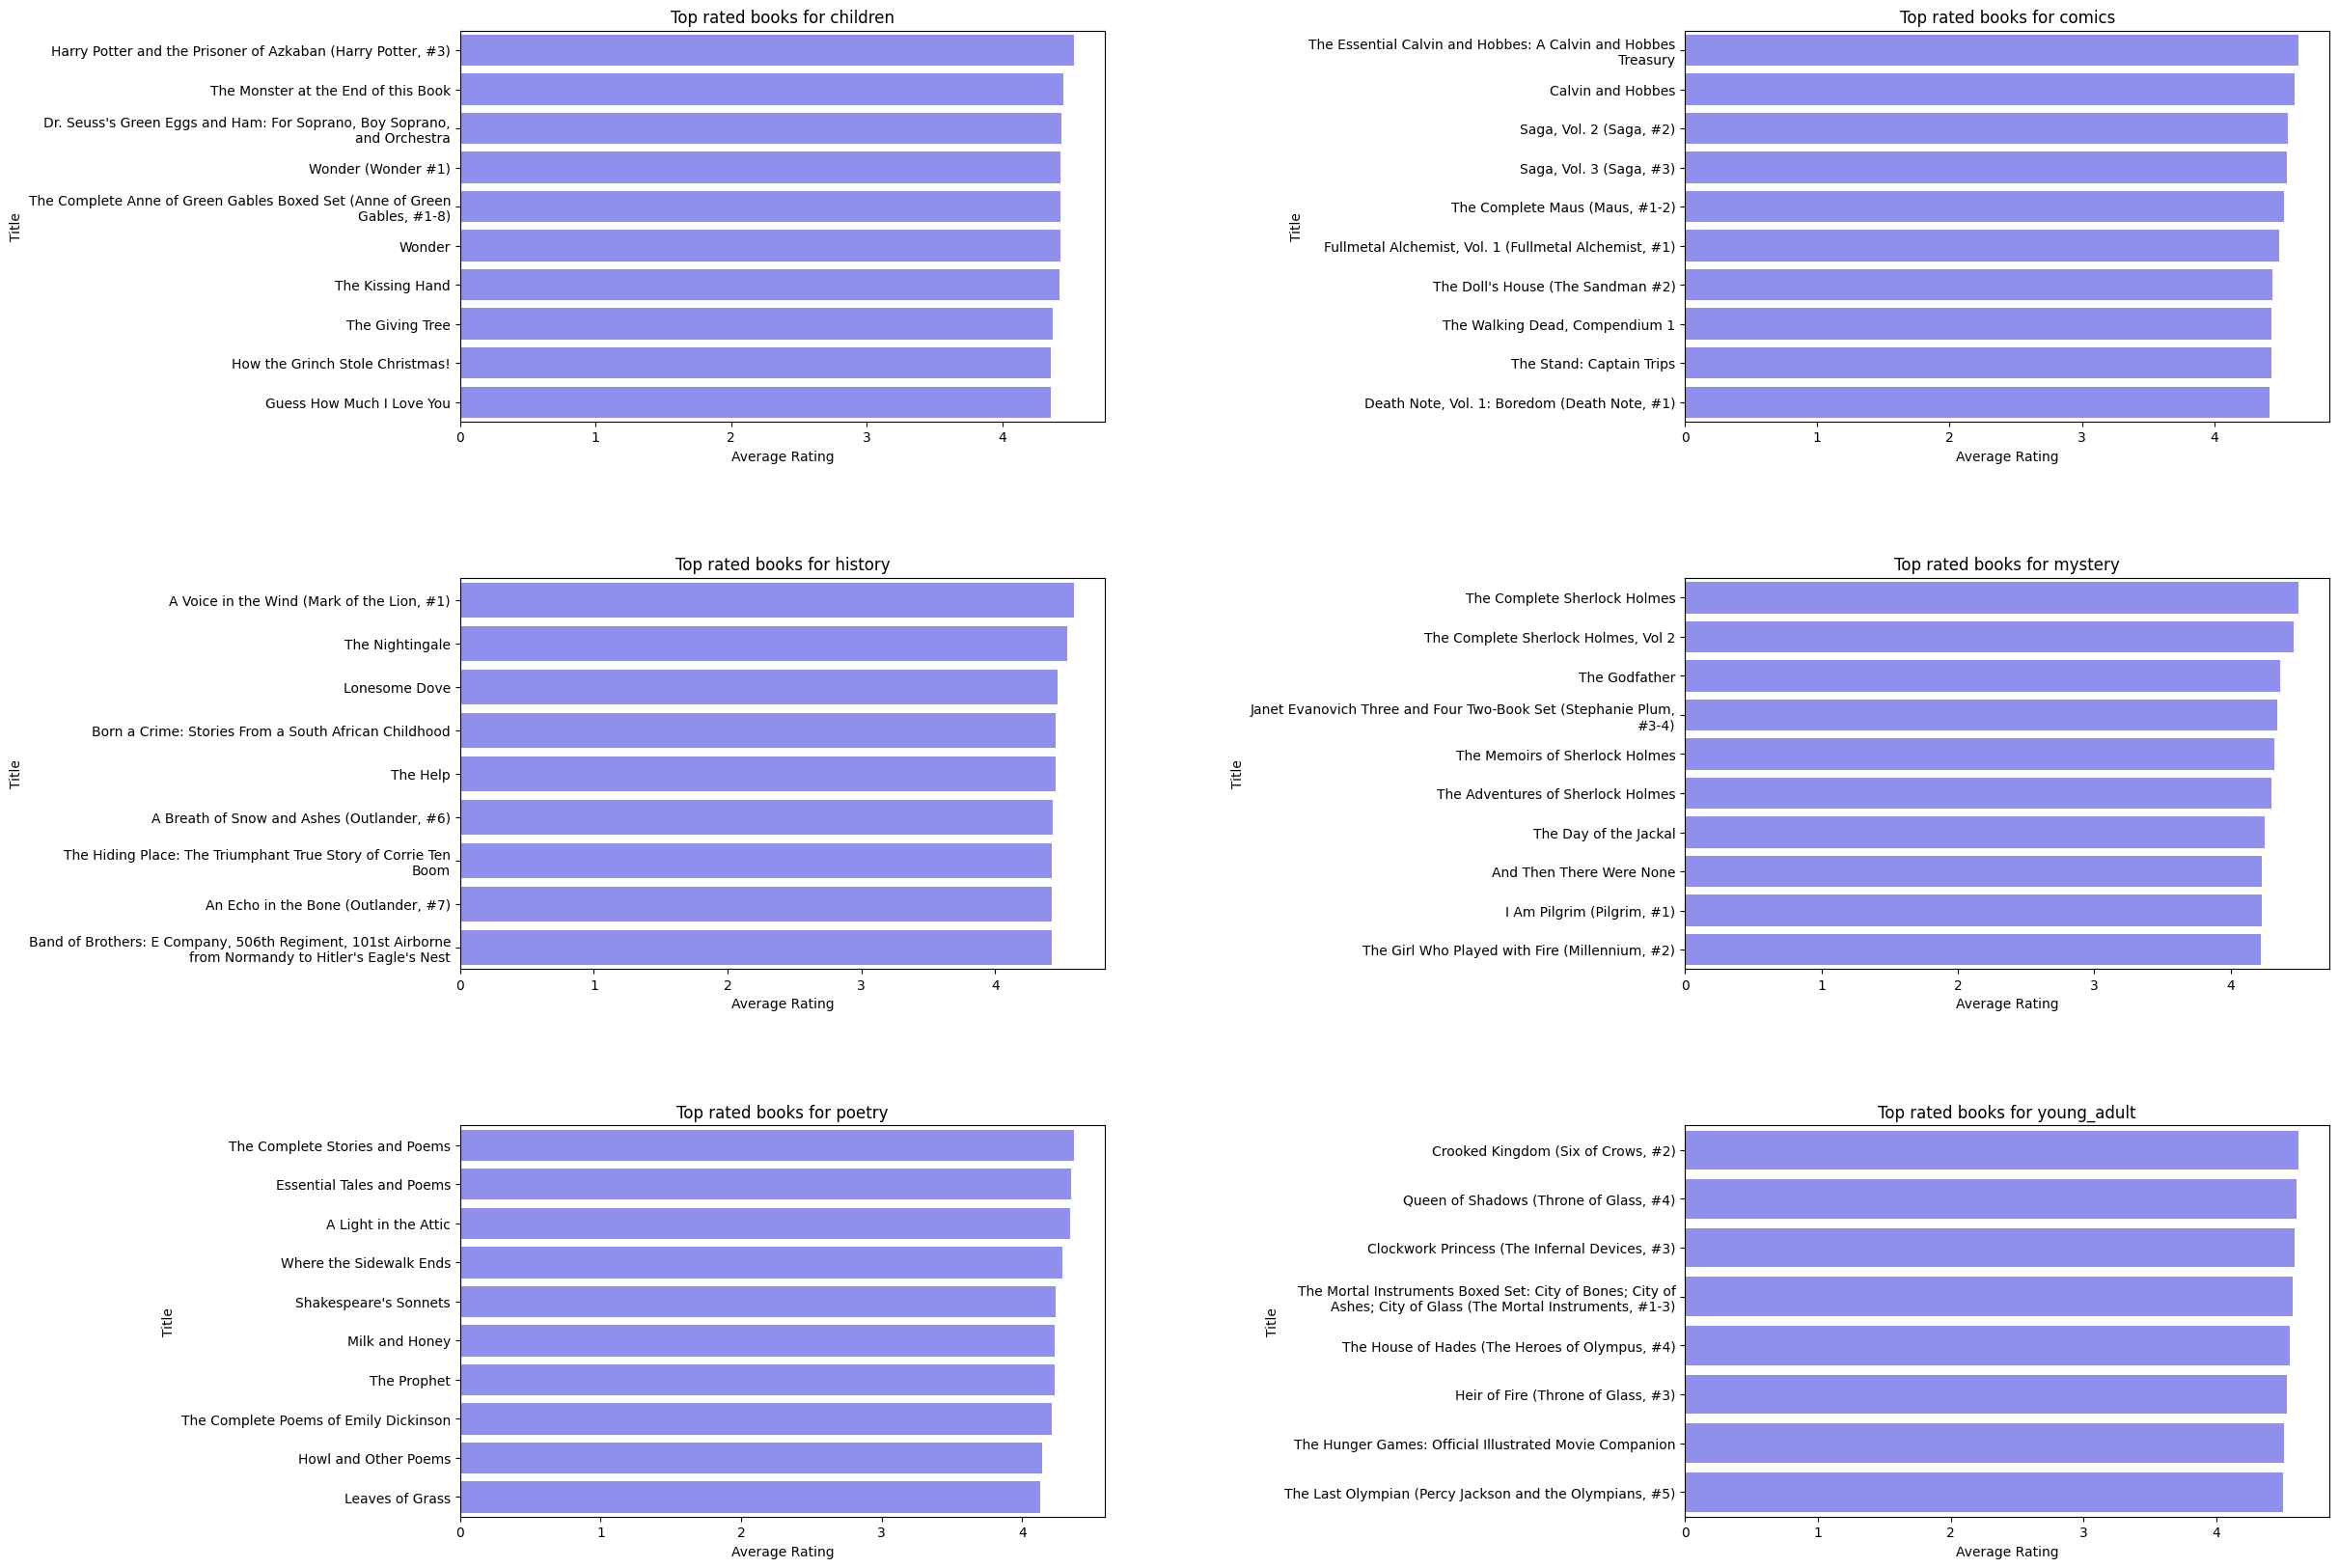

In [260]:
def plot_top_rated_books(df_books):
    all_top_books = []
    
    # Get the most rated books:
    for df in df_books:
        top_books = df[df['ratings_count'] > 50000]
        top_books = top_books.sort_values(by='average_rating', ascending=False).head(10)
        all_top_books.append(top_books)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (25, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.9)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]["average_rating"], y = all_top_books[count]['title'], data = all_top_books[count], color = 'blue', ax = axs[r,c], **kwargs)
            axs[r,c].set_title('Top rated books for ' + df_books[count]['genre'].iloc[0])
            axs[r,c].set_xlabel('Average Rating') 
            axs[r,c].set_ylabel('Title') 

            labels = [textwrap.fill(label.get_text(), 60) for label in ax.get_yticklabels()]
            ax.set_yticklabels(labels)
            count += 1
    plt.show()   

plot_top_rated_books(dfs) 

Most reviwed Books:

In [254]:
df_children.head(1)

,text_reviews_count,country_code,language_code,average_rating,description,authors,num_pages,book_id,ratings_count,title,title_without_series,genre,author_name
0,7,US,,4.13,"Relates in vigorous prose the tale of Aeneas, ...",3041852,162,287141,46,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls,children,Alfred J. Church


In [257]:
def plot_top_text_books(df_books):
    all_top_books = []
    
    # Get the most rated books:
    for df in df_books:
        most_text_reviews = df.sort_values('text_reviews_count',ascending=False).head(10)
        all_top_books.append(most_text_reviews)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.9)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]["text_reviews_count"], y = all_top_books[count]['title'], data = all_top_books[count], ax = axs[r,c], color = 'green', **kwargs)
            axs[r,c].set_title('Books with most text reviews in ' + df_books[count]['genre'].iloc[0])
            axs[r,c].set_xlabel('Text reviews') 
            axs[r,c].set_ylabel('Title') 

            labels = [textwrap.fill(label.get_text(), 60) for label in ax.get_yticklabels()]
            ax.set_yticklabels(labels)
            count += 1
    plt.show()

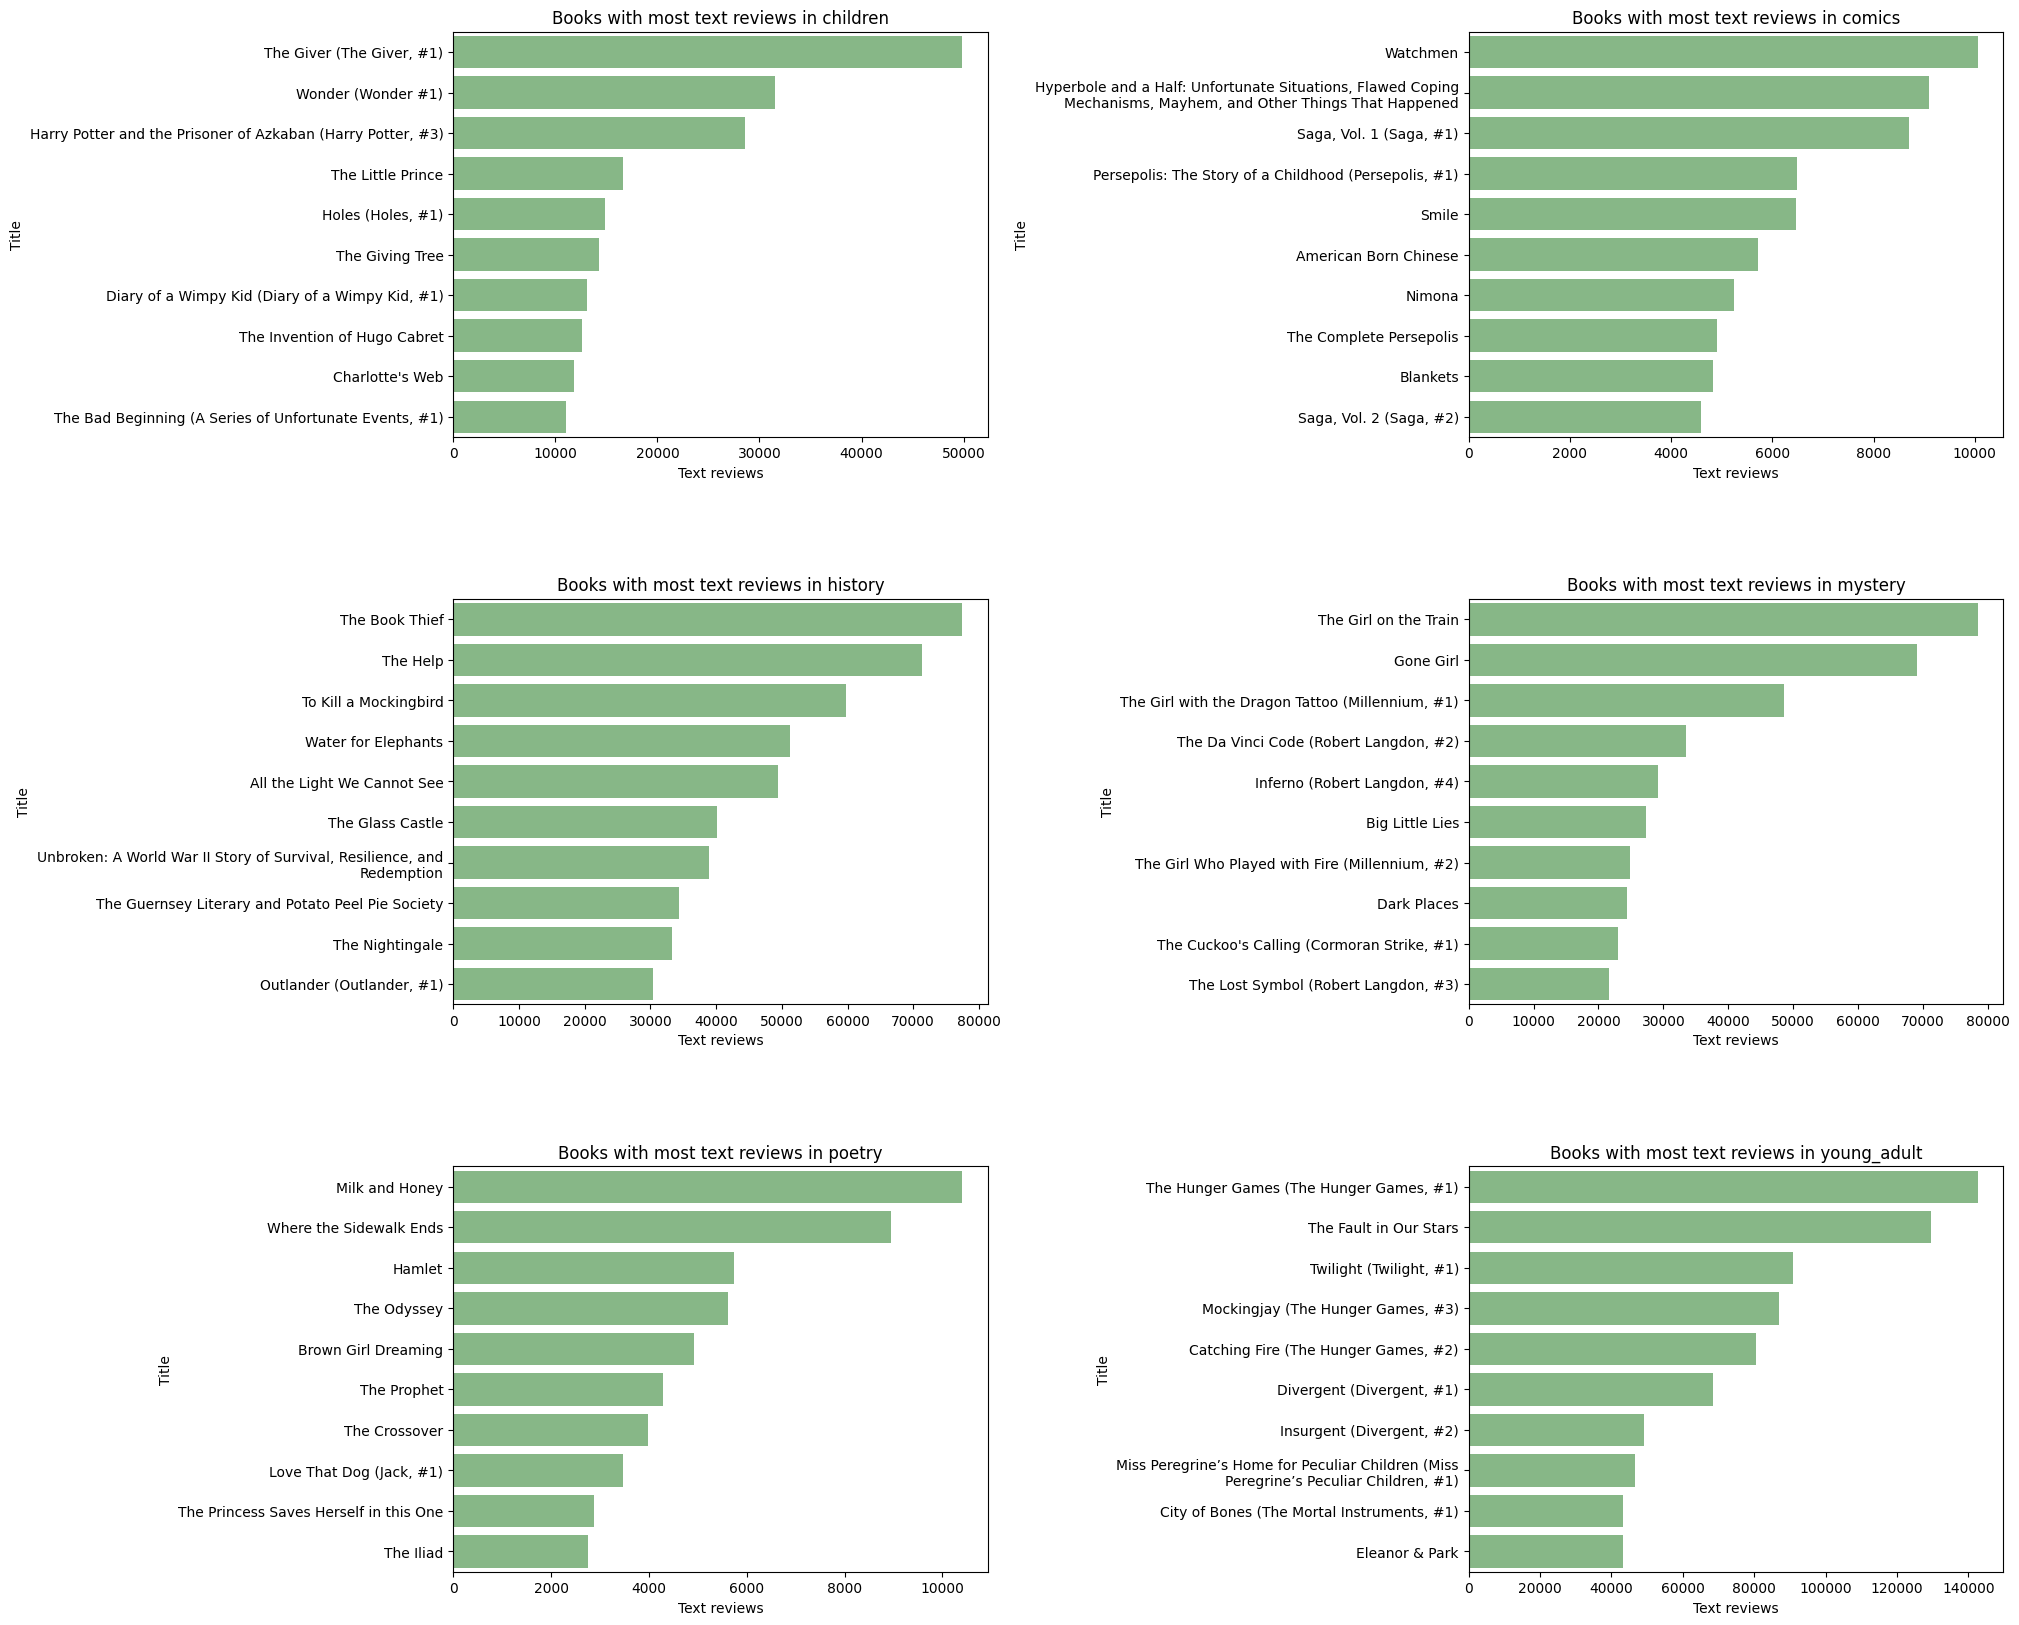

In [258]:
plot_top_text_books(dfs)

Top voted books

In [261]:
def plot_top_vote_books(df_books):
    all_top_books = []
    
    # Get the most rated books:
    for df in df_books:
        top_vote = df.sort_values(by='ratings_count', ascending=False).head(10)
        all_top_books.append(top_vote)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.9)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]["ratings_count"], y = all_top_books[count]['title'], data = all_top_books[count], ax = axs[r,c], **kwargs, color='purple')
            axs[r,c].set_title('Top voted books in ' + df_books[count]['genre'].iloc[0])
            axs[r,c].set_xlabel('Ratings count') 
            axs[r,c].set_ylabel('Title') 

            labels = [textwrap.fill(label.get_text(), 60) for label in ax.get_yticklabels()]
            ax.set_yticklabels(labels)
             
            count += 1
    plt.show()

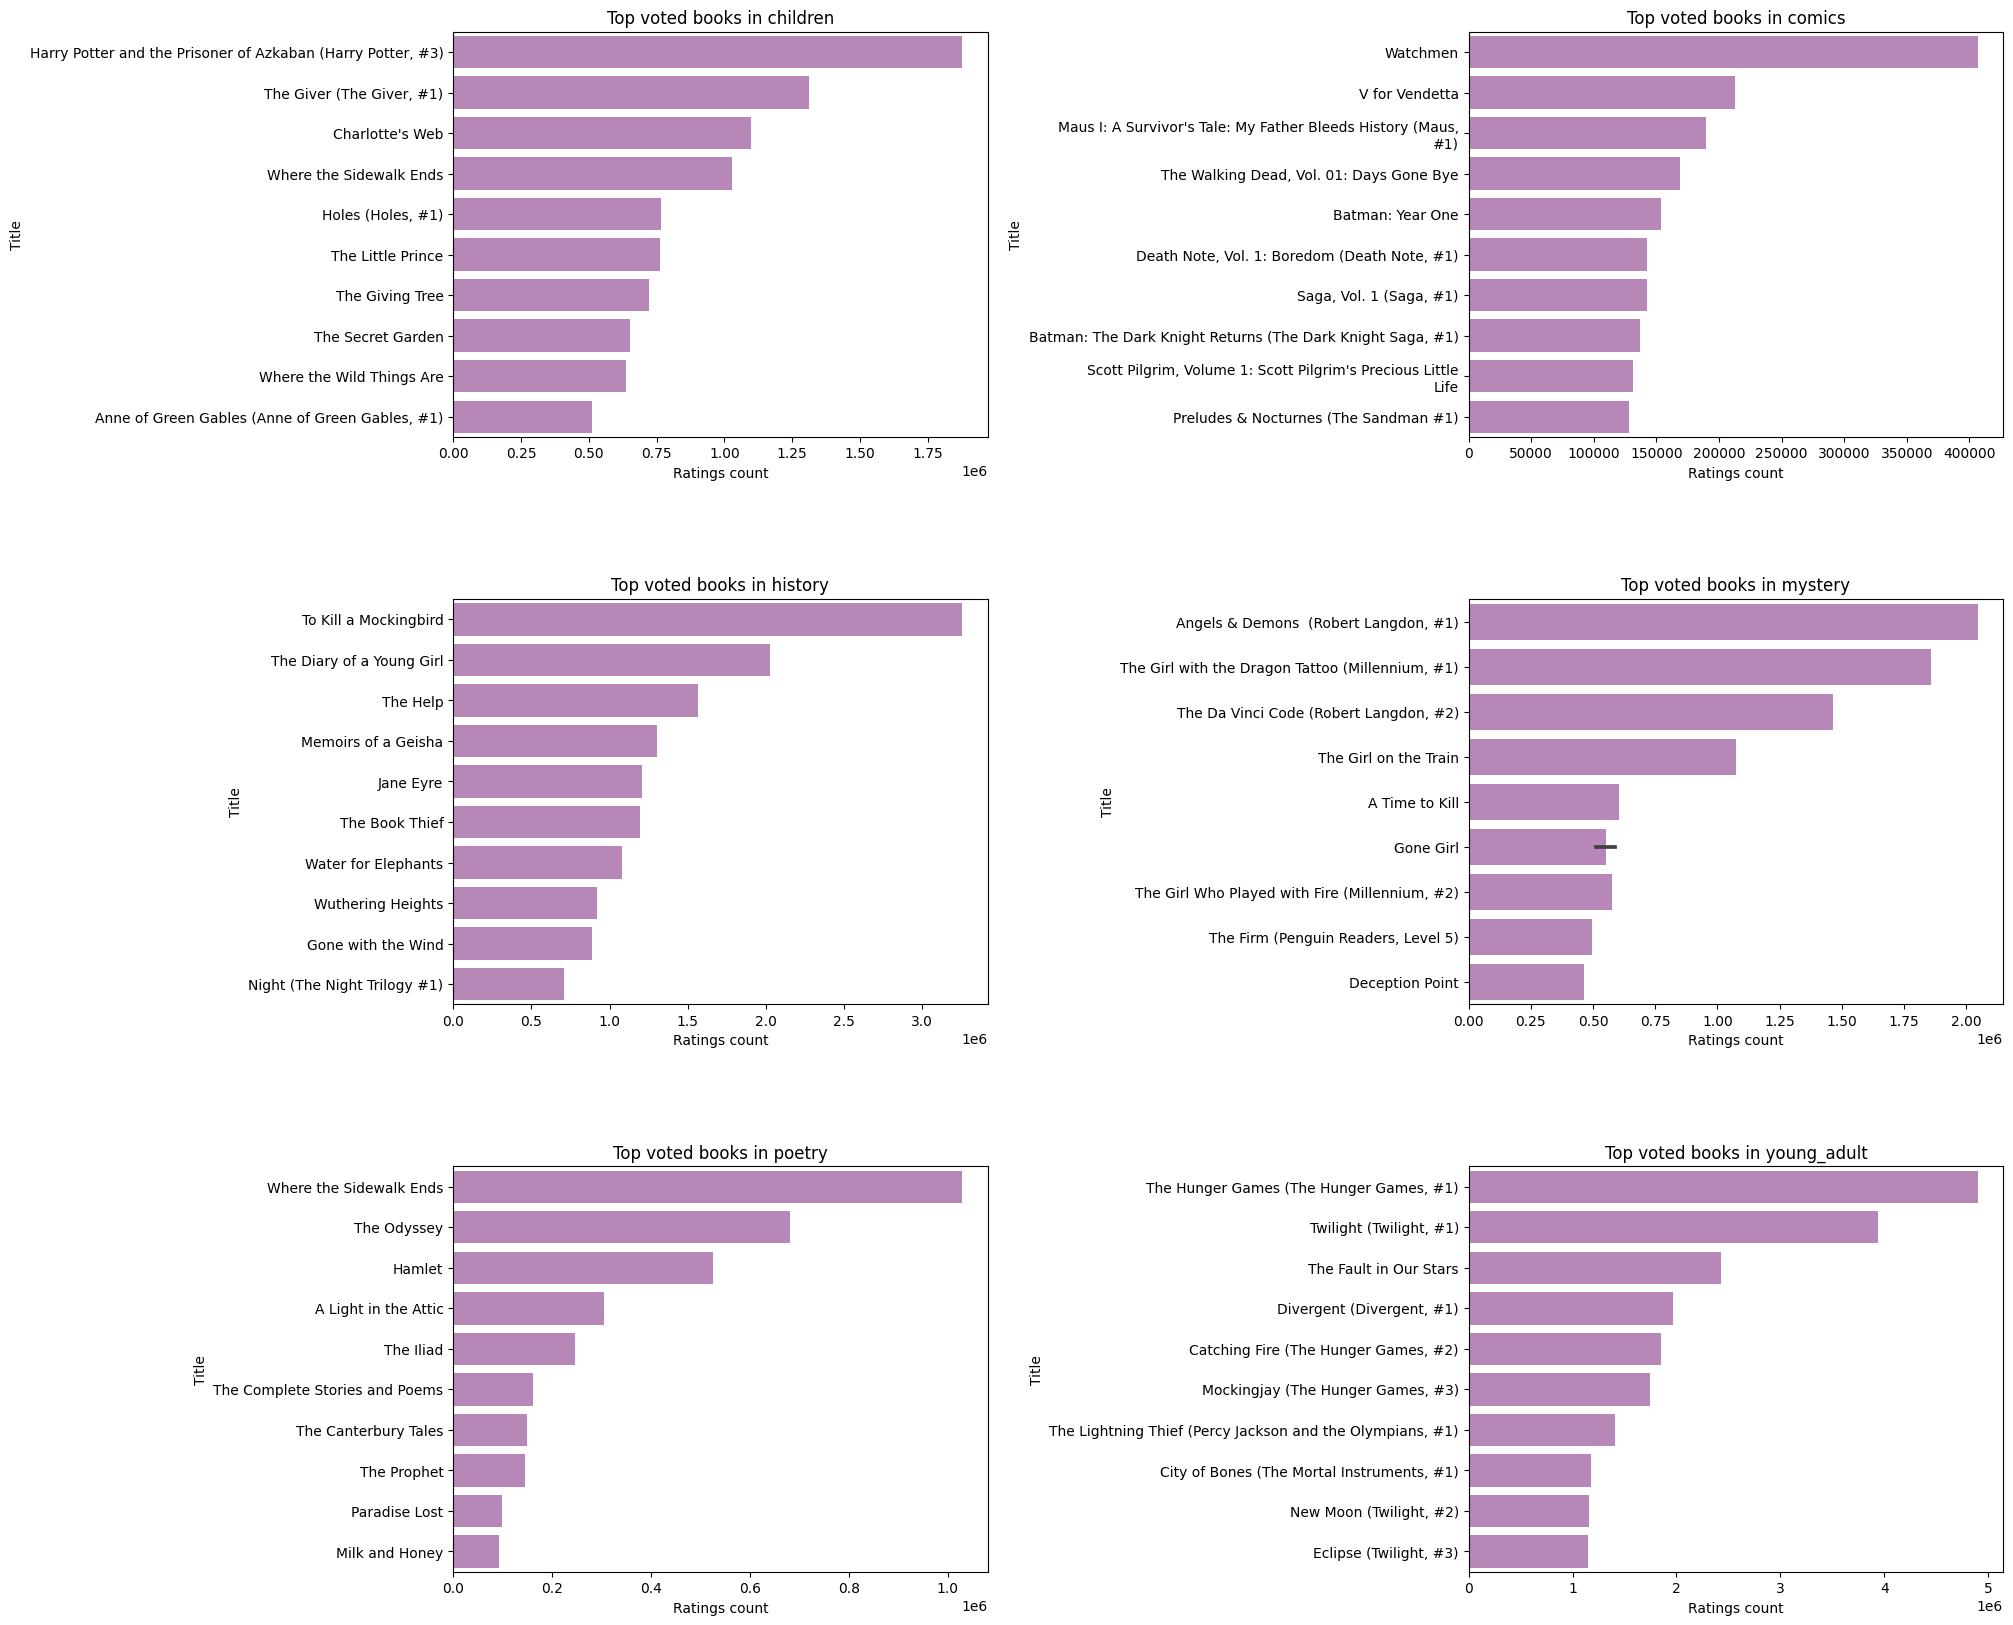

In [262]:
plot_top_vote_books(dfs)

### Author of most books

In [452]:
def plot_top_author(df_books):
    all_top_books = []

    # Get the most rated books:
    for df in df_books:
        
        total_book = df.groupby(by=['author_name_x']).agg({'title': ['nunique']})
        total_book.columns = ['total_book']
        total_book.reset_index
        total_book = total_book.sort_values(by=['total_book'], ascending=False).head(10)
        
        all_top_books.append(total_book)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]['total_book'], y = all_top_books[count].index, data = all_top_books[count], ax = axs[r,c], **kwargs, color='red')
            axs[r,c].set_title('Authors with most books in ' + df_books[count]['genre'].iloc[0])
            count += 1
    
    plt.show()

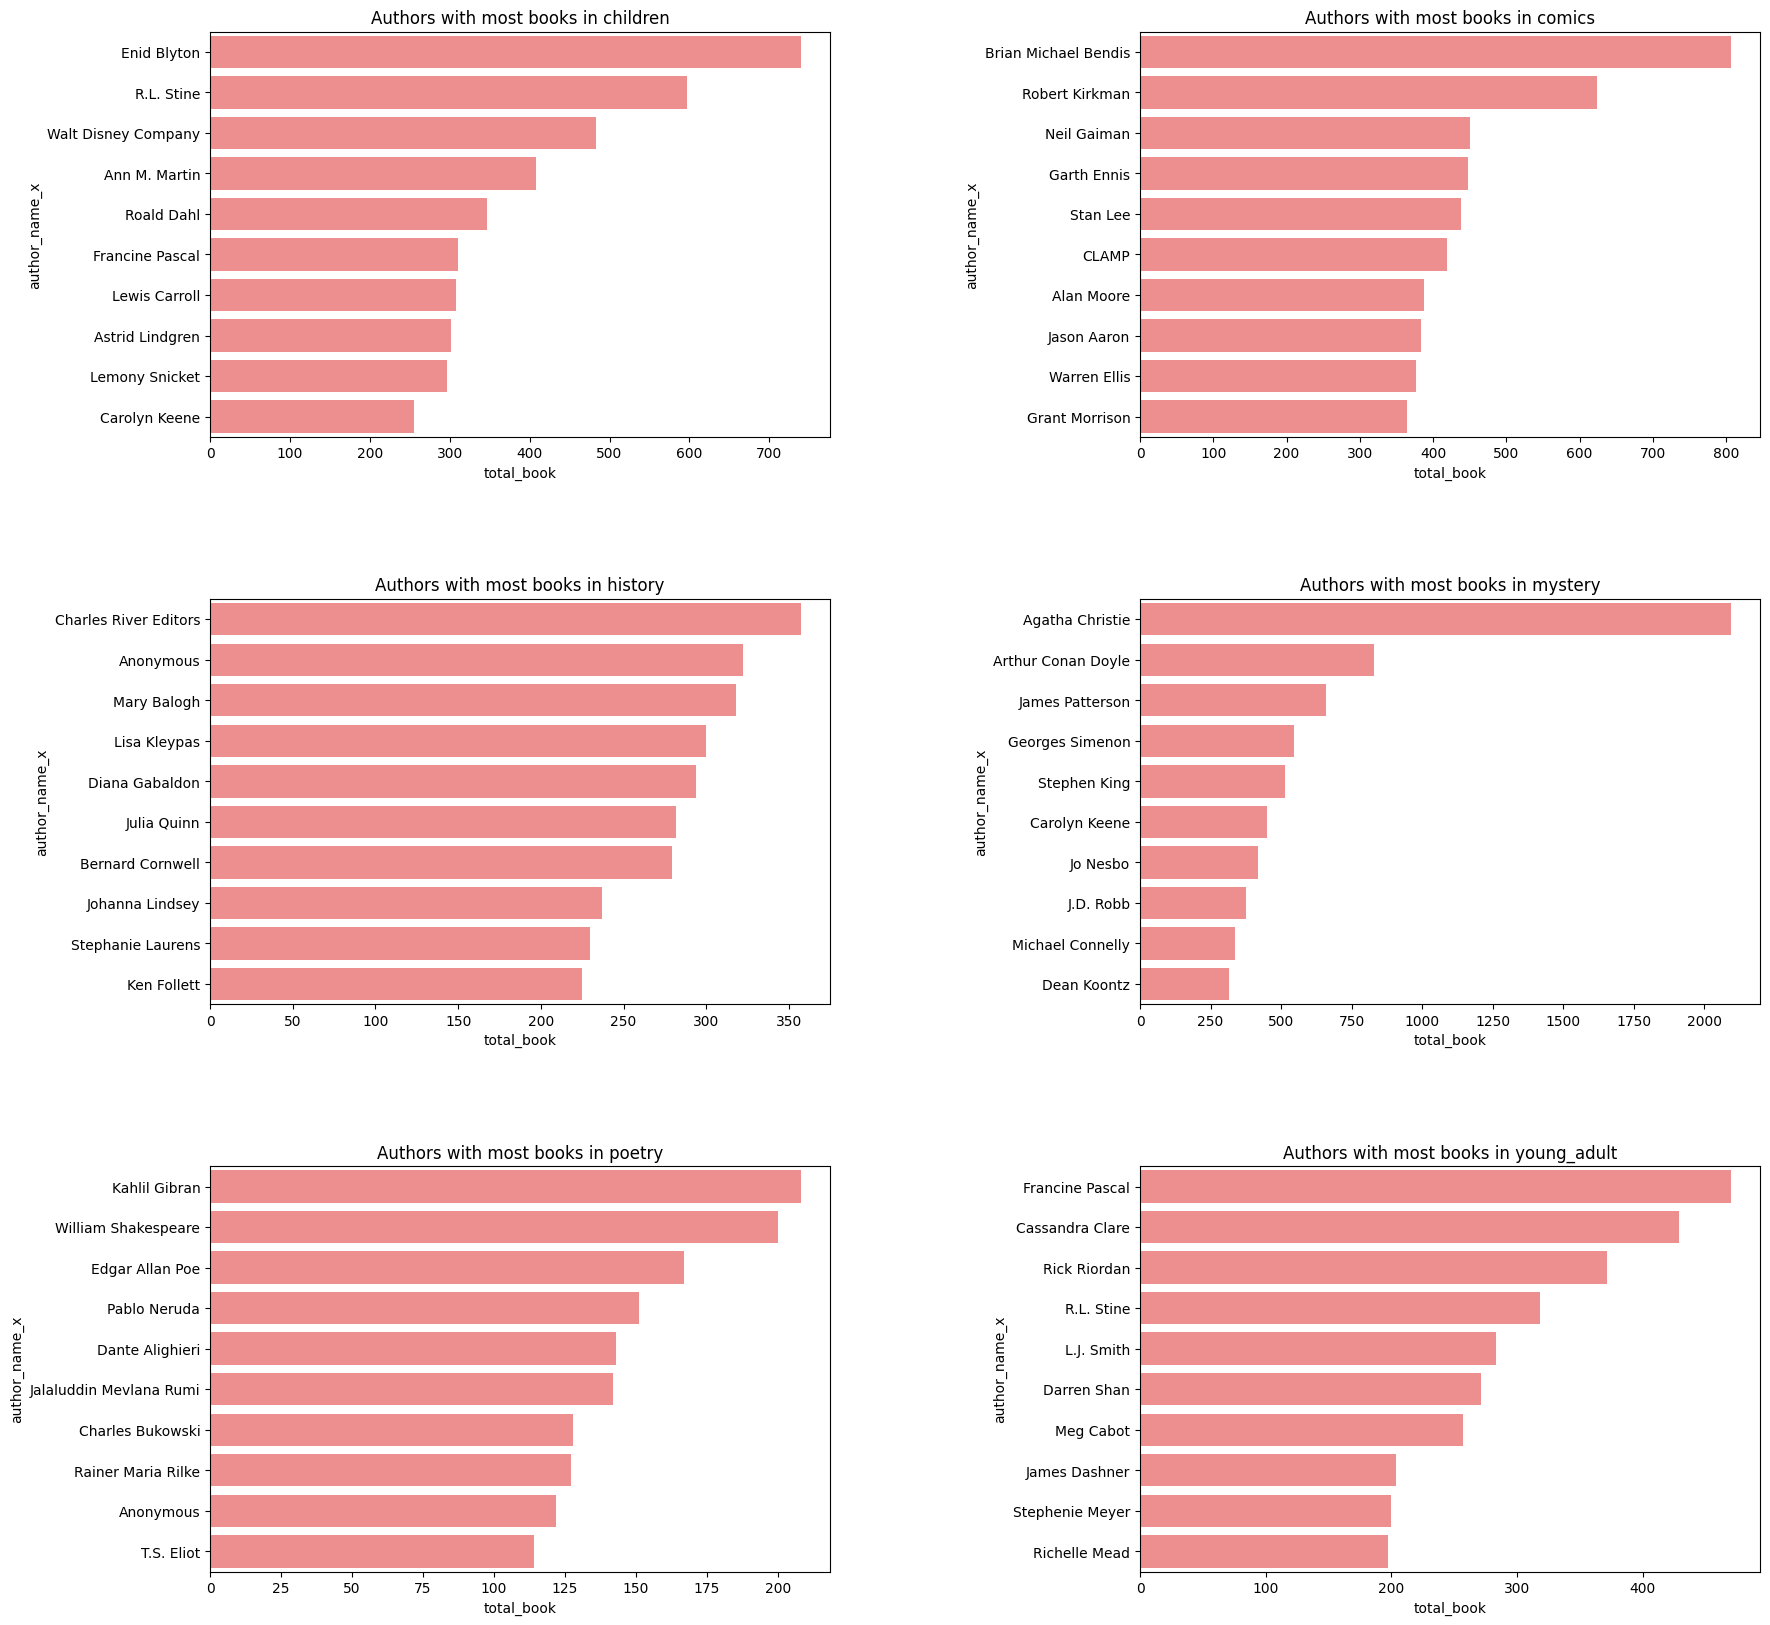

In [453]:
plot_top_author(dfs)

#### Top rated Authors

In [456]:
def plot_top_rated_author(df_books):
    all_top_books = []

    # Get the most rated books:
    for df in df_books:
        top_author = df[df['average_rating'] > 4.0]
        top_author = top_author.groupby(by=['author_name_x']).agg({'average_rating': ['sum']})
        top_author.columns = ['total_rating']
        top_author.reset_index
        top_author = top_author.sort_values(by=['total_rating'], ascending=False).head(10)
        
        all_top_books.append(top_author)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]['total_rating'], y = all_top_books[count].index, data = all_top_books[count], ax = axs[r,c], **kwargs, color='maroon')
            axs[r,c].set_title('Authors with most books in ' + df_books[count]['genre'].iloc[0])
            count += 1
    
    plt.show()

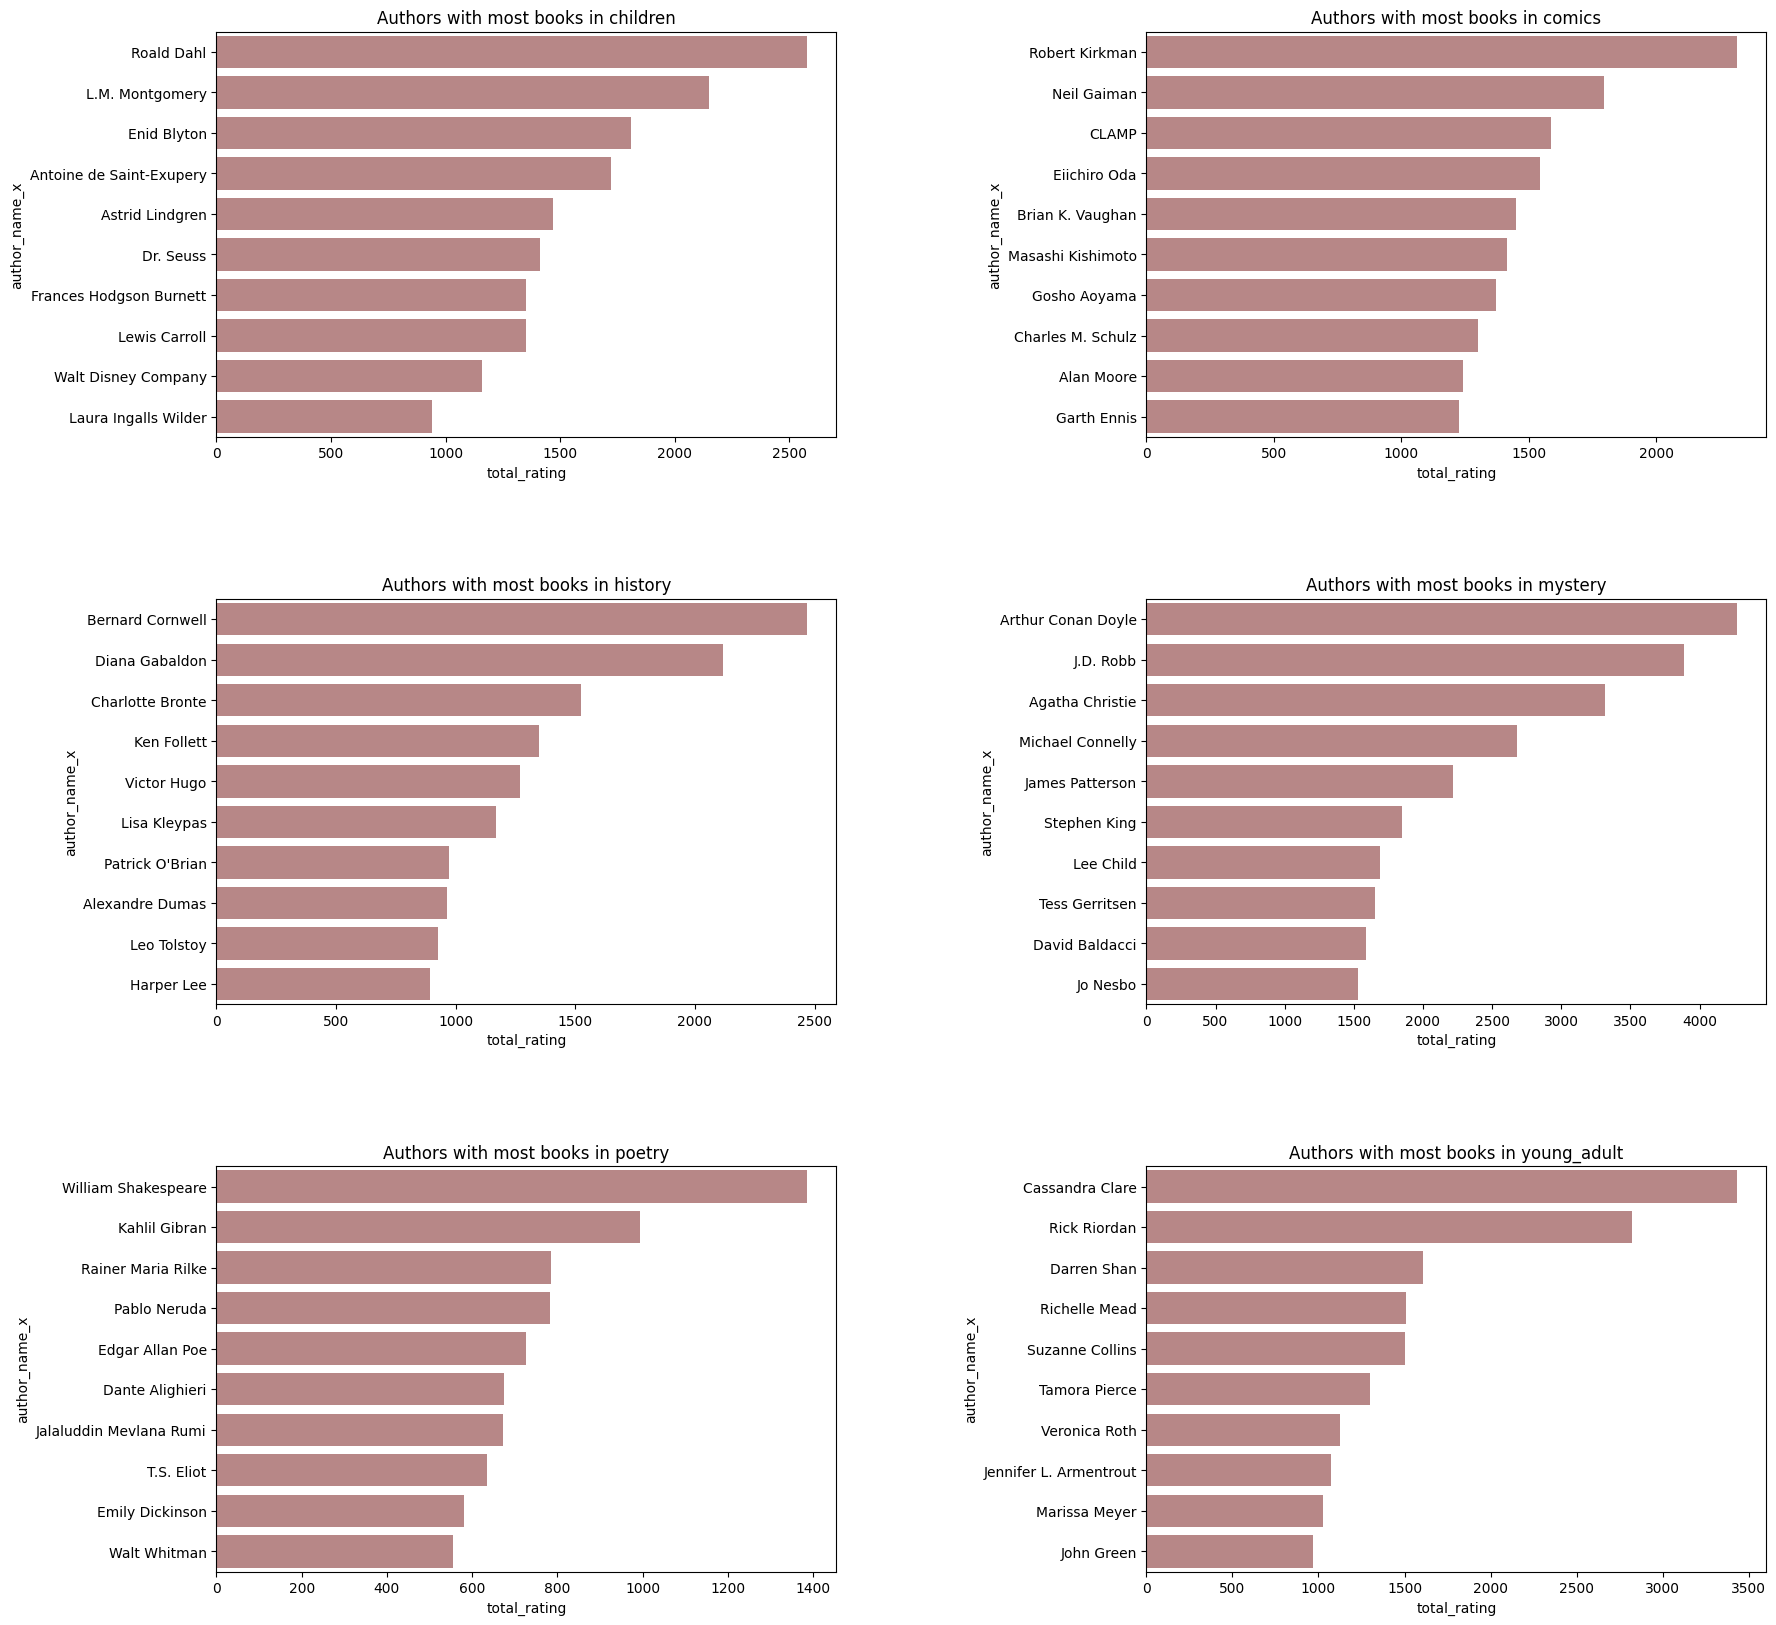

In [457]:
plot_top_rated_author(dfs)

Thickest books:

In [475]:
def plot_top_pages_books(df_books):
    all_top_books = []
    
    # Get the most rated books:
    for df in df_books:
        df['num_pages']=pd.to_numeric(df['num_pages'])
        top_pages = df.sort_values(by='num_pages', ascending = False).head(10)
        all_top_books.append(top_pages)

    '''Plots the top books'''
    rows = 3
    cols = 2
    
    f, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (20, 20))
    plt.subplots_adjust(hspace = 0.4, wspace = 0.9)
    
    count = 0
    for r in range(rows):
        for c in range(cols):
            kwargs = {'alpha':0.5}
            ax = sns.barplot(x = all_top_books[count]["num_pages"], y = all_top_books[count]['title'], data = all_top_books[count], ax = axs[r,c], **kwargs, color='grey')
            axs[r,c].set_title('Top voted books in ' + df_books[count]['genre'].iloc[0])
            axs[r,c].set_xlabel('Ratings count') 
            axs[r,c].set_ylabel('Title') 

            labels = [textwrap.fill(label.get_text(), 60) for label in ax.get_yticklabels()]
            ax.set_yticklabels(labels)
             
            count += 1
    plt.show();

/Users/nina/opt/anaconda3/envs/tflow2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1728 (\N{ARABIC LETTER HEH WITH YEH ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nina/opt/anaconda3/envs/tflow2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


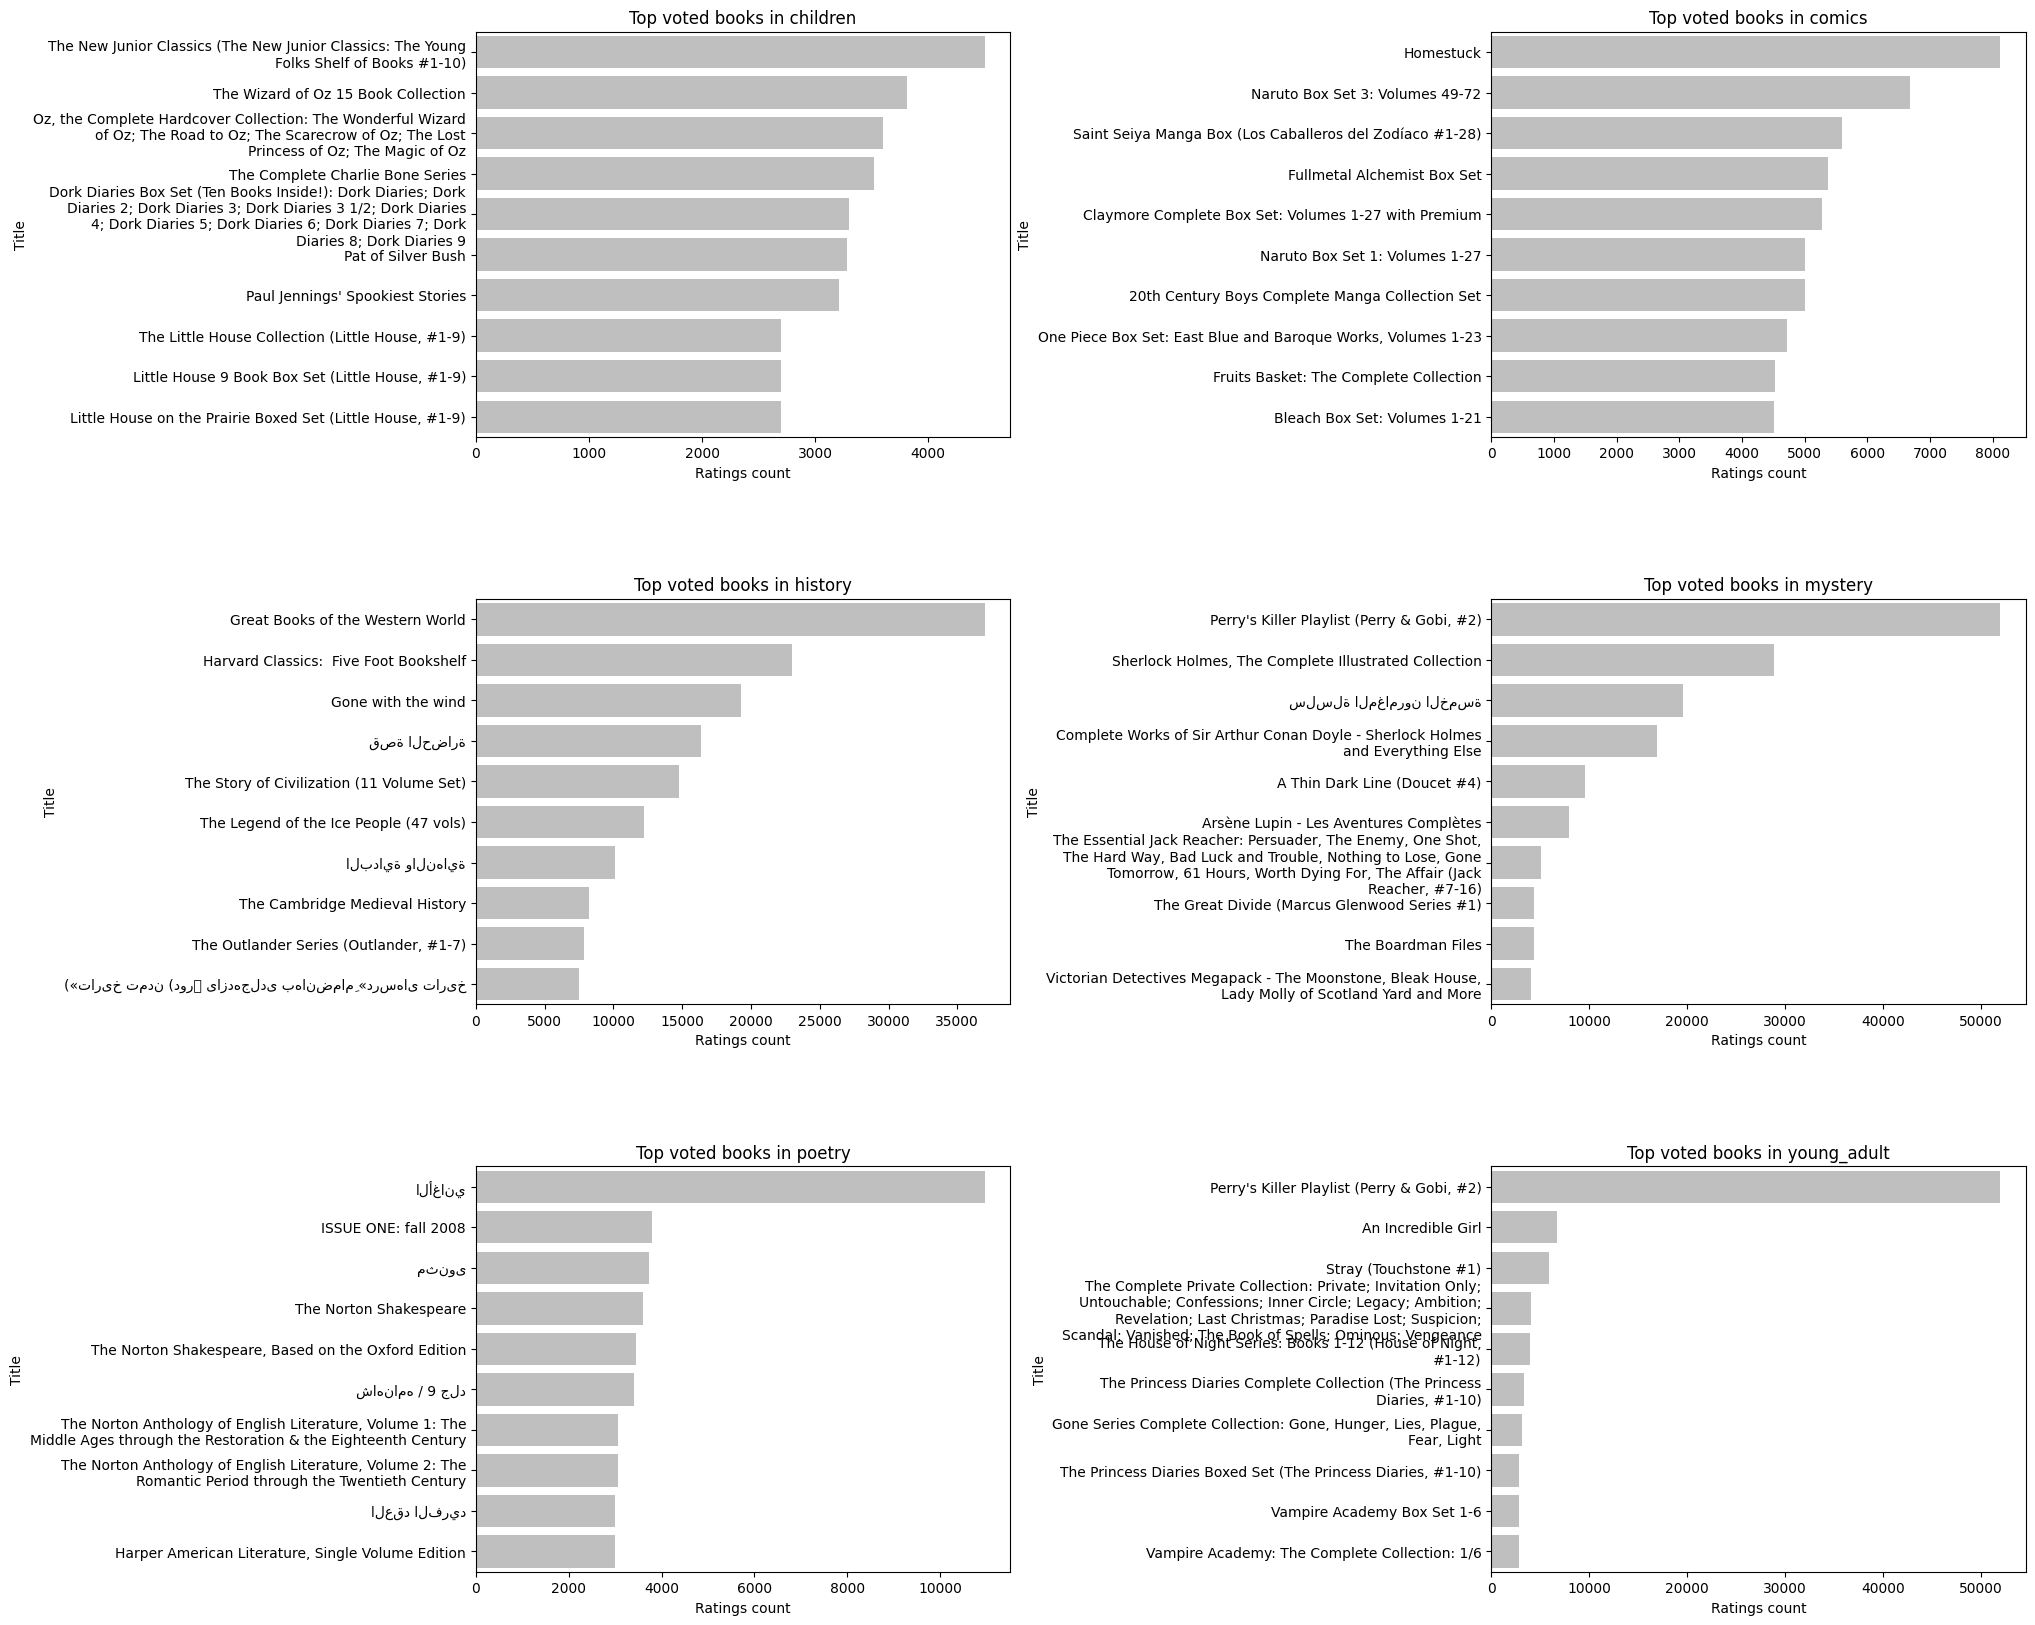

In [476]:
plot_top_pages_books(dfs)

---

#### REVIEWS and RATINGS

In [112]:
#Review dataframe: 
poetry_rev = pd.read_json('./Dataset/goodreads_reviews_poetry.json', lines=True)
poetry_rev.drop(columns=['date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments'], inplace=True)

poetry_rev.to_csv(path_or_buf='./Dataset/poetry_reviews.csv', index=False)

poetry_rev.head()

,user_id,book_id,review_id,rating,review_text
0,3ca7375dba942a760e53b726c472a7dd,402128,28423ff309bc896c071a8d9df4a10e8a,5,I have three younger siblings and we grew up w...
1,0ef32090550901ead25cb0ea21c4d36b,92270,2db1180992e2b0b1631a3ac5644bde84,5,This is my favorite collection of poetry.
2,0ef32090550901ead25cb0ea21c4d36b,908708,bca57fa40e92c9261b00b03dbebd96fe,4,"He's so disturbing. So very, very disturbing."
3,d37b46b2190ed7c518259f29b47a9b36,253264,cb1ebc02d8b2aff15735d513877463ce,5,I just reread this play for a class I am takin...
4,af157d0205b8a901dee6d4a2aed7e6ad,70885,8dca128b8e869048a7442c18659dbece,5,"Cuanto mas leo, mas me gusta. Su poesia es env..."


---

In [10]:
#Create pivot table

data = poetry_rev.pivot_table(index = 'book_id', values = 'rating', columns = 'user_id')

data.head()

user_id,000157a6f8331e9c9a21252e1fee91d1,000192962b87d560f00b06fdcbd71681,0004ae25e3cf5f5a44b6f1ccfdd3d343,0006260f85929db85eddee3a0bd0e504,0006a5b8cda1ba6d7b911dc575f6547b,0008e72711d978c23e3aa3bc7ba3871c,00098165da6612b8b26d453fd19bb754,000a1016fda6008d1edbba720ca00851,000adba19f8f49c25017d68c2a55d90f,000c08303ab122db5baf96607bd55054,...,fff7f660fc5277b7c544dd57dbbf95f3,fffba5600c5d01693b75964e7fbe193f,fffbd84c1c89d775d3568a1362db7ed6,fffbdf4175e907f5a0338d7a4a7a8e4e,fffc34d137f5c5c5e1ca1d6f325a4dcf,fffc475c53c2c59e160a4274aec002cf,fffcf6da0f39d7ab624e2a8da054d2c3,fffe3fca0160bd78ae5828b44fbeb72d,fffe68bb5313dd3733d25e3097beedf3,ffff601c0ffa34bd5ffbbf2caee30644
book_id,,,,,,,,,,,,,,,,,,,,,
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36412 entries, 234 to 36485479
Columns: 47400 entries, 000157a6f8331e9c9a21252e1fee91d1 to ffff601c0ffa34bd5ffbbf2caee30644
dtypes: float64(47400)
memory usage: 12.9 GB


In [12]:
sparse_data = sparse.csr_matrix(data.fillna(0).values)

In [23]:
import sys

sys.getsizeof(data), sys.getsizeof(sparse_data)

(13807721712, 48)

## Cosine similarity

In [64]:
cosine_distances(sparse_data)

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [65]:
pairwise_distances(sparse_data, metric='cosine')

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [66]:
similarity_matrix = cosine_similarity(sparse_data)

In [13]:
sim_sparse = cosine_similarity(sparse_data, dense_output = False)

In [68]:
pd.DataFrame(
    similarity_matrix,
    index = data.index,
    columns = data.index
)

book_id,234,236,241,244,254,284,285,286,289,290,...,36393749,36403877,36407928,36410118,36417323,36418610,36441514,36443173,36447192,36485479
book_id,,,,,,,,,,,,,,,,,,,,,
234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36418610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36441514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
36443173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [14]:
rec_df = pd.DataFrame.sparse.from_spmatrix(
    sim_sparse,
    index = data.index,
    columns = data.index
)

In [15]:
rec_df.reset_index()

book_id,book_id,234,236,241,244,254,284,285,286,289,...,36393749,36403877,36407928,36410118,36417323,36418610,36441514,36443173,36447192,36485479
0,234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,236,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,241,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,244,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36407,36418610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36408,36441514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
36409,36443173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
36410,36447192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
rec_df[234].sort_values(ascending = False).head(10)

book_id
234         1.000000
601717      0.492366
333100      0.492366
3096023     0.492366
1184908     0.492366
3223649     0.492366
13573337    0.492366
4372479     0.492366
9477587     0.492366
409657      0.492366
Name: 234, dtype: Sparse[float64, 0]

In [185]:
def get_cosine_similarities(book_title, df): 
    if poetry_1['title'].str.contains(book_title).any():
        found_book = poetry_1[poetry_1['title'].str.contains(book_title)]
        found_book_id = found_book['book_id'].iloc[0]
        found_book_title = found_book['title'].iloc[0]

        print(f"My book is {found_book_title}")

        matched_books = []
        recs = rec_df[found_book_id].sort_values(ascending = False).head(20)

        for i, v in recs.items():
            if i != found_book_id:
                match_book = poetry_1[poetry_1['book_id'] == i]    
                match_book_title = match_book['title'].iloc[0]

                matched_books.append({
                    'book_id': i,
                    'title': match_book_title,
                    'value': v
                })
        
        matches_df = pd.DataFrame(matched_books)
        return matches_df


    else:
        return False

f = get_cosine_similarities('Dark Sons', rec_df) 
f.head(20)



My book is Dark Sons


,book_id,title,value
0,234,The Complete Verse and Other Nonsense,0
1,14578651,Stepping Over Seasons,0
2,14553489,When Thunder Comes: Poems for Civil Rights Lea...,0
3,14553491,A Strange Place to Call Home: The World's Most...,0
4,14553840,I Could Pee on This: And Other Poems by Cats,0
5,14562809,The Conference of Birds,0
6,14563663,Gods of Babel,0
7,14571182,Adventures in Form,0
8,14580479,Hummingbird,0
9,14546605,Floating Life,0


## Nearest neighbour

In [ ]:
poetry = file_read('poetry')
fix_author(poetry)
poetry = add_author_name(poetry, df_authors)

#poetry.to_csv(path_or_buf='./Dataset/poetry.csv', index=False)

poetry_reviews = poetry_rev.pivot_table(index='book_id', values='rating').fillna(0)
mat_poetry_reviews = sparse.csr_matrix(poetry_reviews.values)

In [123]:
from fuzzywuzzy import process
import pickle

def get_knn(book_title, data, review_data):
    model = NearestNeighbors(algorithm='brute', n_neighbors = 40)
    model.fit(review_data)

    # knnPickle = open('./Dataset/poetry_knn_model.pkl', 'wb') 
    # pickle.dump(model, knnPickle)  
    # knnPickle.close()

    book_idx = process.extractOne(book_title, data['title'])[2]
    print('Selected book: ',data['title'][book_idx])
    
    matched_books = []
    indices = model.kneighbors(review_data[book_idx], n_neighbors=40)[1]

    for i in indices[0]:
        if i != book_idx:  
            matched_books.append({
                'book_id': data['book_id'][i],
                'title': data['title'][i],
                'author': data['author_name'][i]
            })
        
    matches_df = pd.DataFrame(matched_books)
    return matches_df
  
recs = get_knn('love', poetry, mat_poetry_reviews) 
recs.head(20)


Selected book:  Love


,book_id,title,author
0,17226753,Eurooppalainen kuolemankirja: Valitut runot,J.K. Ihalainen
1,17805294,A Spell of Songs,Peter Jay Shippy
2,8013567,Il Profeta,Kahlil Gibran
3,1590511,Blue Lash: Poems,James Armstrong
4,11382,Cuttlefish Bones,Eugenio Montale
5,15702028,حالات و مقامات م. امید,mHmdrD shfy`y khdkhny
6,17306620,Oikukas tuuli: toinen valikoima japanilaisia t...,Tuomas Anhava
7,381853,Realizing the Impossible: Art Against Authority,Josh MacPhee
8,1281355,On the Bus with Rosa Parks: Poems,Rita Dove
9,3315096,ماه و تنهایی عاشقان,Ono no Komachi
